In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import helpers
import os
from matplotlib import pyplot as plt

import numpy as np
import networkx as nx
from sklearn.metrics import log_loss
from decentralized_SGD_logistic import DecentralizedSGDLogistic
from sklearn.linear_model import SGDClassifier

## Load Higgs Boson dataset

In [3]:
y, A = helpers.load_data()

## Compute the baseline with SGD classifier 

In [4]:
# Fit a SGD
clf = SGDClassifier(loss='log', penalty='l2', alpha =1/A.shape[0], tol=1e-4, n_jobs=1, random_state=2)
clf.fit(A, y)

accuracy = clf.score(A, y)
optimum_x = clf.predict_proba(A)[:, 1]

# Optimal loss, useful for plots
optimum_loss = (-(y.T.dot(np.log(optimum_x)) + (1 - y).T.dot(np.log(1 - optimum_x))) / A.shape[0])

print('Accuracy:', accuracy)
print('Final loss:', optimum_loss)

Accuracy: 0.7444
Final loss: 0.5063267378689544


## Computing with Decentralized SGD

### Cycle topologies to be used

In [9]:
def cycle_rw(p, n_states):
    """Return the transition matrix of a Markov chain corresponding
    to a cyclic random walk (no self-loops)
    :param p: the probability of going to one of the neighboring states
    :param n_states: number of states in the Markov chain"""
    q = 1-p

    W = np.zeros(shape=(n_states, n_states))
    np.fill_diagonal(W[1:], q, wrap=False)
    np.fill_diagonal(W[:, 1:], p, wrap=False)
    W[0, n_states - 1] = q
    W[n_states - 1, 0] = p
    return W

In [10]:
def cycle_lazy_rw(lazy_p, p, n_states):
    """Return the transition matrix of a Markov chain corresponding
    to a lazy cyclic random walk (self-loops are included)
    :param lazy_p: the probability of staying at the same state
    :param p: the probability of going to one of the neighboring states
    :param n_states: number of states in the Markov chain"""
    if lazy_p + p > 1:
        raise ValueError('Wrong proba')
    q = 1-p - lazy_p

    W = np.zeros(shape=(n_states, n_states))
    np.fill_diagonal(W, lazy_p, wrap=False)
    np.fill_diagonal(W[1:], q, wrap=False)
    np.fill_diagonal(W[:, 1:], p, wrap=False)
    W[0, n_states - 1] = q
    W[n_states - 1, 0] = p
    return W

In [34]:
reg = 1 / A.shape[0]
n_features = A.shape[1]
n_machines = 512
compute_loss_every = 5

params = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.1, regularizer=reg,
                           quantization_method='full', n_machines=n_machines,
                           communication_method='plain',
                           data_distribution_random_seed=2, random_seed=2,
                           data_distribution_strategy='random', tol=1e-10, compute_loss_every=compute_loss_every)

### Comparison Unbalanced Ring with no self-loops VS Unbalanced Ring with self-loops

In [35]:
params_cyle_rw = params.copy()
params_cyle_rw['topology'] = cycle_rw(0.7, n_machines)
list_losses_rw = helpers.run_logistic_n_times(A, y, params_cyle_rw, 3)


params_cyle_lazy_rw = params.copy()
params_cyle_lazy_rw['topology'] = cycle_lazy_rw(0.3, 0.6, n_machines)
list_losses_lazy_rw = helpers.run_logistic_n_times(A, y, params_cyle_lazy_rw, 3)

Decentralized optimization, run number 1 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [488/488]      24s       3.7840    0.6835        
[2/5]      [488/488]      50s       6.3214    0.6822        
[3/5]      [488/488]      73s       7.6109    0.6820        
[4/5]      [488/488]      95s       8.2979    0.6826        
[5/5]      [488/488]      117s      8.7461    0.6829        

Final score: 0.6829
Decentralized optimization, run number 2 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [488/488]      25s       3.7674    0.6842        
[2/5]      [488/488]      51s       6.3488    0.6828        
[3/5]      [488/488]      73s       7.6044    0.6825        
[4/5]      [488/488]      95s       8.3950    0.6822        
[5/5]      [488/488]      118s      8.9189    0.6818        

Final score: 0.6818
Decentralized optimization, run number 3 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [488/488]      22s       

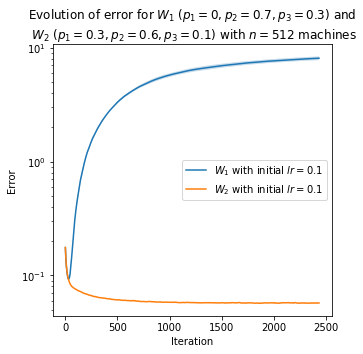

In [63]:
iterations_indices = np.arange(0, list_losses_rw[0].shape[0] * compute_loss_every, compute_loss_every)
title = 'Evolution of error for $W_1 \; (p_1=0, p_2=0.7, p_3=0.3)$ and\n $W_2 \; (p_1=0.3, p_2=0.6, p_3=0.1)$ with $n=512$ machines'
labels = ['$W_1$ with initial $lr=0.1$','$W_2$ with initial $lr=0.1$']

helpers.plot_losses_with_std([list_losses_rw, list_losses_lazy_rw],
            iterations_indices, optimum_loss=optimum_loss, 
            labels=labels, title=title, figsize=(5,5))

### Comparison Ring with no self-loops VS Ring close to no self-loops

In [37]:
params_cycle_rw_new = params.copy()
params_cycle_rw_new['topology'] = cycle_rw(0.5, n_machines)
list_losses_rw_new = helpers.run_logistic_n_times(A, y, params_cycle_rw_new, 3)

params_cycle_lazy_rw_new = params.copy()
params_cycle_lazy_rw_new['topology'] = cycle_lazy_rw(0.01, 0.5, n_machines)
list_losses_lazy_rw_new = helpers.run_logistic_n_times(A, y, params_cycle_lazy_rw_new, 3)

params_cycle_rw_new2 = params_cycle_rw_new.copy()
params_cycle_rw_new2['initial_lr'] = 0.01
list_losses_rw_new2 = helpers.run_logistic_n_times(A, y, params_cycle_rw_new2, 3)

params_cycle_lazy_rw_new2 = params_cycle_lazy_rw_new.copy()
params_cycle_lazy_rw_new2['initial_lr'] = 0.01
list_losses_lazy_rw_new2 = helpers.run_logistic_n_times(A, y, params_cycle_lazy_rw_new2, 3)

Decentralized optimization, run number 1 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [488/488]      25s       3.8826    0.6832        
[2/5]      [488/488]      48s       6.3414    0.6821        
[3/5]      [488/488]      73s       7.5656    0.6825        
[4/5]      [488/488]      100s      8.2355    0.6828        
[5/5]      [488/488]      127s      8.6828    0.6831        

Final score: 0.6831
Decentralized optimization, run number 2 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [488/488]      26s       3.9160    0.6834        
[2/5]      [488/488]      50s       6.3692    0.6829        
[3/5]      [488/488]      72s       7.6194    0.6825        
[4/5]      [488/488]      96s       8.2971    0.6826        
[5/5]      [488/488]      121s      8.7372    0.6829        

Final score: 0.6829
Decentralized optimization, run number 3 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [488/488]      25s       

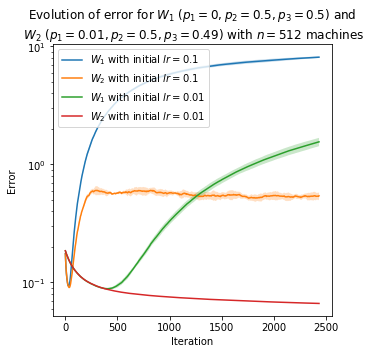

In [62]:
iterations_indices = np.arange(0, list_losses_rw_new[0].shape[0] * compute_loss_every, compute_loss_every)
title = 'Evolution of error for $W_1 \; (p_1=0, p_2=0.5, p_3=0.5)$ and\n $W_2 \; (p_1=0.01, p_2=0.5, p_3=0.49)$ with $n=512$ machines'
labels = ['$W_1$ with initial $lr=0.1$', '$W_2$ with initial $lr=0.1$', '$W_1$ with initial $lr=0.01$', '$W_2$ with initial $lr=0.01$']

helpers.plot_losses_with_std([list_losses_rw_new, list_losses_lazy_rw_new,list_losses_rw_new2, list_losses_lazy_rw_new2],
            iterations_indices, optimum_loss=optimum_loss, 
            labels=labels, title=title, figsize=(5,5))